# setup

## libraries

In [ ]:
import os
import zipfile
import shutil
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from progressbar import progressbar
from sklearn.model_selection import train_test_split
from google.colab import drive
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
plt.rcParams['font.size'] = 14

In [ ]:
# load gdrive folder
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# setup device to train on gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# data

## environment variables

In [ ]:
PATH = os.path.abspath('/content/gdrive/MyDrive/ArtistClass/')

## extract

In [ ]:
# unzip data
path_to_zip_file = '/content/gdrive/MyDrive/ArtistClass/data.zip'
directory_to_extract_to = '/content/gdrive/MyDrive/ArtistClass/data'

if not os.path.exists(directory_to_extract_to):
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

In [ ]:
# check unzip list extracted directory
os.listdir(directory_to_extract_to)[:10]

['artists.csv', 'images', 'resized', 'train', 'test']

## split train/test

In [ ]:
# format data intro train/test sets
# read artist data
artists_path = os.path.join(PATH, 'data/artists.csv')
df_artists = pd.read_csv(artists_path)

df_top = df_artists.sort_values('paintings', ascending=False)[['name', 'paintings']].head(10)
df_top['name'] = df_top['name'].str.replace(' ', '_')

df_top

,name,paintings
8,Vincent_van_Gogh,877
30,Edgar_Degas,702
13,Pablo_Picasso,439
15,Pierre-Auguste_Renoir,336
19,Albrecht_Dürer,328
46,Paul_Gauguin,311
16,Francisco_Goya,291
31,Rembrandt,262
20,Alfred_Sisley,259
32,Titian,255


In [ ]:
train_path = os.path.join(PATH, 'data', 'train')
test_path = os.path.join(PATH, 'data', 'test')

In [ ]:
# clear train test directories
if os.path.exists(train_path):
    shutil.rmtree(train_path)

if os.path.exists(test_path):
    shutil.rmtree(test_path)

# make train test directories
os.mkdir(train_path)
os.mkdir(test_path)

In [ ]:
# copy images to ImageLoader structure
for artist in df_top['name']:

    # paths
    artist_path = os.path.join(PATH, 'data/images/images', artist)
    artist_train_path = os.path.join(PATH, 'data/train', artist)
    artist_test_path = os.path.join(PATH, 'data/test', artist)
    
    if os.path.exists(artist_path):

        # delete artist train/test paths
        if os.path.exists(artist_train_path):
            shutil.rmtree(artist_train_path)
        
        if os.path.exists(artist_test_path):
            shutil.rmtree(artist_test_path)

        # create train test directories
        os.mkdir(artist_train_path)
        os.mkdir(artist_test_path)

        # train/test split images
        images = os.listdir(artist_path)
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=3301)

        # copy train images
        for image in progressbar(train_images, prefix=f'train/{artist} '):

            image_source_path = os.path.join(artist_path, image)
            image_target_path = os.path.join(artist_train_path, image)

            shutil.copy(image_source_path, image_target_path)

        # copy test images
        for image in progressbar(test_images, prefix=f'test/{artist} '):

            image_source_path = os.path.join(artist_path, image)
            image_target_path = os.path.join(artist_test_path, image)

            shutil.copy(image_source_path, image_target_path)

train/Vincent_van_Gogh 100% (701 of 701) || Elapsed Time: 0:00:19 Time:  0:00:19
test/Vincent_van_Gogh 100% (176 of 176) || Elapsed Time: 0:00:02 Time:  0:00:02
train/Edgar_Degas 100% (561 of 561) |####| Elapsed Time: 0:00:12 Time:  0:00:12
test/Edgar_Degas 100% (141 of 141) |#####| Elapsed Time: 0:00:01 Time:  0:00:01
train/Pablo_Picasso 100% (351 of 351) |##| Elapsed Time: 0:00:07 Time:  0:00:07
test/Pablo_Picasso 100% (88 of 88) |#####| Elapsed Time: 0:00:00 Time:  0:00:00
train/Pierre-Auguste_Renoir 100% (268 of 268) || Elapsed Time: 0:00:05 Time:  0:00:05
test/Pierre-Auguste_Renoir 100% (68 of 68) || Elapsed Time: 0:00:00 Time:  0:00:00
train/Paul_Gauguin 100% (248 of 248) |###| Elapsed Time: 0:00:05 Time:  0:00:05
test/Paul_Gauguin 100% (63 of 63) |######| Elapsed Time: 0:00:00 Time:  0:00:00
train/Francisco_Goya 100% (232 of 232) |#| Elapsed Time: 0:00:04 Time:  0:00:04
test/Francisco_Goya 100% (59 of 59) |####| Elapsed Time: 0:00:00 Time:  0:00:00
train/Rembrandt 100% (209 of 2

## torch datasets

In [ ]:
# transforms
# TODO: agregar transformaciones aleatorias
loader_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    
])

In [ ]:
# datasets
train_dataset = ImageFolder(root=train_path, transform=loader_transforms)
test_dataset = ImageFolder(root=test_path, transform=loader_transforms)

In [ ]:
# dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Neural Network

## architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__() # hereda todo de nn.Module

        # definimos arquitecura de la red
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120) # fc: fully connected
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 porque tenemos 10 categorías

        self.drop_out = nn.Dropout()

    # forward prop / backward prop
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) #funcion de activacion -- no linealidad 
        x = F.relu(self.fc2(x)) #funcion de activacion -- no linealidad 
        x = F.softmax(self.fc3(x), dim=1)

        return x

In [ ]:
# instantiate
cnn = CNN()
cnn.to(device) # send to device (cpu/gpu)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (drop_out): Dropout(p=0.5, inplace=False)
)

## optimizer

In [ ]:
criterion = nn.CrossEntropyLoss() # loss para problemas de multiple-classification
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9) # SGD: stochastic gradient descent

## train

In [ ]:
epochs = 100

In [ ]:
# loop de entrenamiento: cada iteración de esta cosa actualiza los pesos de la red
loss_history = []
for epoch in progressbar(range(epochs), prefix='Epoc: '):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # sacar la derivada
        optimizer.step()  # gradient descent

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
            # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            # running_loss = 0.0

    loss_history.append(running_loss)
print('Finished Training')

Epoc: 100% (100 of 100) |################| Elapsed Time: 3:15:30 Time:  3:15:30


Finished Training


In [ ]:
model_path = os.path.join(PATH, f'model_{epochs}_epochs.pth')

In [ ]:
# save trained model
torch.save(cnn.state_dict(), model_path)

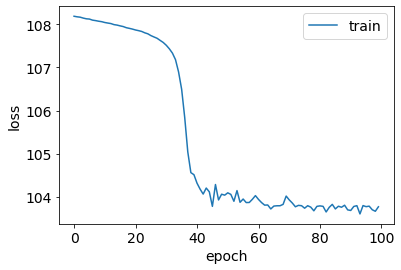

In [ ]:
# plot train loss over training
fig, ax = plt.subplots()
ax.plot(loss_history, label='train')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

# evaluate classifier

In [ ]:
model_path = os.path.join(PATH, f'model_100_epochs.pth')

In [ ]:
# load moel
net = CNN()
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
# image iterator
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

In [ ]:
# evaluate predictions over all dataset
correct = 0
total = 0

# no gradient necessary, only needed for training
with torch.no_grad():
    for data in test_dataloader:
        # load batch
        images, labels = data

        # calculate outputs by running images through the network
        outputs = net(images)

        # the class with the highest activation value is the predicted class
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test set: {100 * correct // total} %')

Accuracy of the network on test set: 26 %
